# Exact "good" frames from video, generate depth map

In [1]:
import cv2
import numpy as np
import os

In [2]:
video_filename = "/media/harry7557558/OS/Archive/sfm_videos/20230612_021029.mp4"

cap = cv2.VideoCapture(video_filename)
assert cap.isOpened()


fi = 0
skip = 10
keep = 8

iqms = []
frames_buf = []
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # frame = cv2.bilateralFilter(frame, 5, 40, 40)

    s = 256
    gray = cv2.cvtColor(cv2.resize(frame, (2*s, 2*s)), cv2.COLOR_BGR2GRAY)
    mu, sigma = np.mean(gray), np.std(gray)
    gray = (gray-mu)#/sigma

    # fft = np.fft.fft2(gray)[:s, :s]
    # fft = (fft * np.conjugate(fft)).real
    # iqm = np.sum(fft[5:, 5:]) / np.sum(fft)
    # iqm = np.mean(fft > (np.amax(fft)/1000))

    # plt.imshow(np.log(fft))
    # break

    iqm = cv2.Laplacian(gray, cv2.CV_64F).var()

    iqms.append((mu, sigma, iqm))

    frames_buf.append((fi, iqm, frame))
    if len(frames_buf) > keep:
        del frames_buf[0]

    fi += 1
    if fi % skip == 0:
        frame = sorted(frames_buf, key=lambda x: x[1], reverse=True)[0]
        frames.append(frame)

cap.release()

print(len(frames), '/', len(iqms), 'frames')


34 / 347 frames


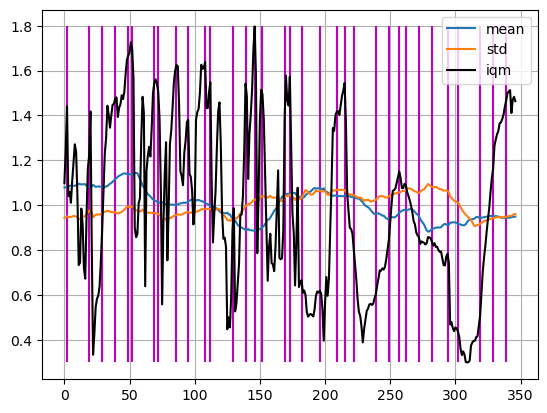

In [3]:
import matplotlib.pyplot as plt

iqms = np.array(iqms)
iqms /= np.mean(iqms, axis=0)
plt.plot(iqms[:,0], label='mean')
plt.plot(iqms[:,1], label='std')
plt.plot(iqms[:,2], 'k', label='iqm')

plt.vlines([_[0] for _ in frames], np.min(iqms), np.max(iqms), 'm', '-')

plt.legend()
plt.grid()
plt.show()

def imshow(img):
    import IPython
    # img = cv2.resize(img, (512, 512))
    if len(img.shape) == 2:
        img = img.reshape((1, *img.shape))
    if img.shape[0] == 1:
        img = np.array([img, img, img])
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
# for fi, iqm, frame in frames:
#     imshow(frame)

In [4]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import sys, os
depth_anything_path = "/home/harry7557558/GitHub/external/Depth-Anything/"
sys.path += [depth_anything_path]
current_directory = os.getcwd()
os.chdir(depth_anything_path)

from depth_anything.dpt import DepthAnything

encoder = 'vits' # can also be 'vitb' or 'vitl'
model = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder))
model = model.to(device)

os.chdir(current_directory)

cuda


/home/harry7557558/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
xFormers not available
xFormers not available


Image size: (770, 1372, 3)
1 / 34 1631.1562030023197 ms
2 / 34 281.09727600531187 ms
3 / 34 281.08924100524746 ms
4 / 34 293.6259240086656 ms
5 / 34 284.10416199767496 ms
6 / 34 283.03920399048366 ms
7 / 34 287.9665990039939 ms
8 / 34 285.30822100583464 ms
9 / 34 284.4553629984148 ms
10 / 34 283.1294269999489 ms
11 / 34 288.1381629995303 ms
12 / 34 288.2607520004967 ms
13 / 34 283.10128999873996 ms
14 / 34 288.29241399944294 ms
15 / 34 287.46294300071895 ms
16 / 34 285.55410700209904 ms
17 / 34 286.3924400007818 ms
18 / 34 288.4434279985726 ms
19 / 34 287.9022819979582 ms
20 / 34 286.39966499758884 ms
21 / 34 287.9921529965941 ms
22 / 34 286.5659590024734 ms
23 / 34 285.38044600281864 ms
24 / 34 289.3738169950666 ms
25 / 34 286.9426410034066 ms
26 / 34 288.02174200245645 ms
27 / 34 287.3969450010918 ms
28 / 34 288.5388650029199 ms
29 / 34 288.48993600695394 ms
30 / 34 290.37442499247845 ms
31 / 34 288.19126899179537 ms
32 / 34 290.42669900809415 ms
33 / 34 288.99248800007626 ms
34 / 34

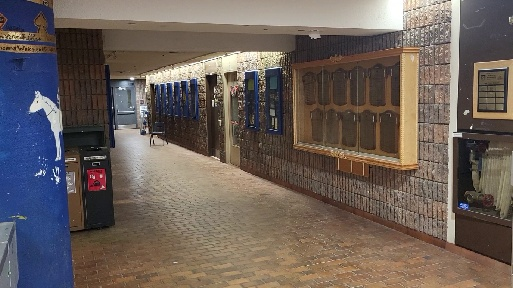

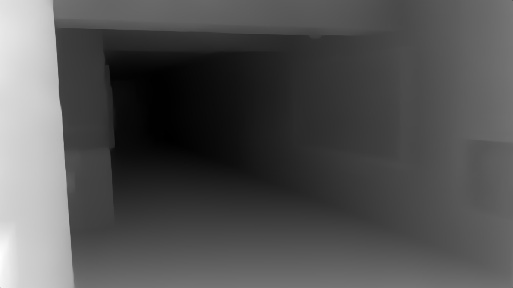

In [5]:
import scipy.ndimage

rgbs = []
depths = []

for i, (fi, iqm, frame) in enumerate(frames):
    x = frame
    scale = 1024/(x.shape[0]*x.shape[1])**0.5
    w = int(x.shape[0]*scale/14+0.5)*14
    h = int(x.shape[1]*scale/14+0.5)*14
    x = cv2.resize(x, (h, w))

    if i == 0:
        print("Image size:", x.shape)

    x = np.array(x, dtype=np.float32) / 255.0
    x = np.transpose(x, (2, 0, 1))

    from time import perf_counter
    with torch.no_grad():
        time0 = perf_counter()
        
        mu = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((3, 1, 1))
        sigma = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((3, 1, 1))
        xc = torch.tensor((x-mu)/sigma, device=device).unsqueeze(0)
        y = model(xc)[0].cpu().numpy()

        time1 = perf_counter()
    print(i+1, '/', len(frames), 1000*(time1-time0), 'ms')

    scale = 384/(x.shape[1]*x.shape[2])**0.5
    x = scipy.ndimage.zoom(x, (1, scale, scale), order=0)
    y = scipy.ndimage.zoom(y, (scale, scale), order=0)
    x = np.transpose(x, (1, 2, 0))
    x = np.clip(x, 0.0, 1.0)
    y = (y-np.amin(y))/(np.amax(y)-np.amin(y))
    rgbs.append((255*x+0.5).astype(np.uint8))
    depths.append((65535*y+0.5).astype(np.uint16))

np.savez_compressed("frames.npz",
                    rgb=np.array(rgbs),
                    depth=np.array(depths))

imshow(255*x)
imshow(255*y.reshape(*y.shape, 1))
